In [12]:
# Cell 1: Imports

import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier
plt.style.use("seaborn-v0_8")

MODEL_NAME = "pipeline_random_forest.joblib"  # change if needed
model = joblib.load(MODEL_NAME)
print("Loaded model:", MODEL_NAME)


Loaded model: pipeline_random_forest.joblib


In [18]:
# Memory-safe CSV loading using chunks (RECOMMENDED)

from pathlib import Path
import pandas as pd

DATA_PATH = next(p for p in possible_paths if p.exists())

CHUNK_SIZE = 200_000
MAX_ROWS = 500_000   # enough for explainability

chunks = []
rows_loaded = 0

for chunk in pd.read_csv(
    DATA_PATH,
    chunksize=CHUNK_SIZE
):
    chunks.append(chunk)
    rows_loaded += len(chunk)
    if rows_loaded >= MAX_ROWS:
        break

df = pd.concat(chunks, ignore_index=True)
print("Loaded rows:", df.shape)


C:\Users\devvr\AppData\Local\Temp\ipykernel_29536\2151928440.py:14: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(
C:\Users\devvr\AppData\Local\Temp\ipykernel_29536\2151928440.py:14: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(
C:\Users\devvr\AppData\Local\Temp\ipykernel_29536\2151928440.py:14: DtypeWarning: Columns (19,55,112) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(


Loaded rows: (600000, 145)


In [20]:
pre = model.named_steps["pre"]
clf = model.named_steps["clf"]

num_cols = pre.named_transformers_["num"].feature_names_in_
cat_cols = pre.named_transformers_["cat"]["encoder"].get_feature_names_out()

feature_names = np.concatenate([num_cols, cat_cols])
print("Total model features:", len(feature_names))


Total model features: 434899


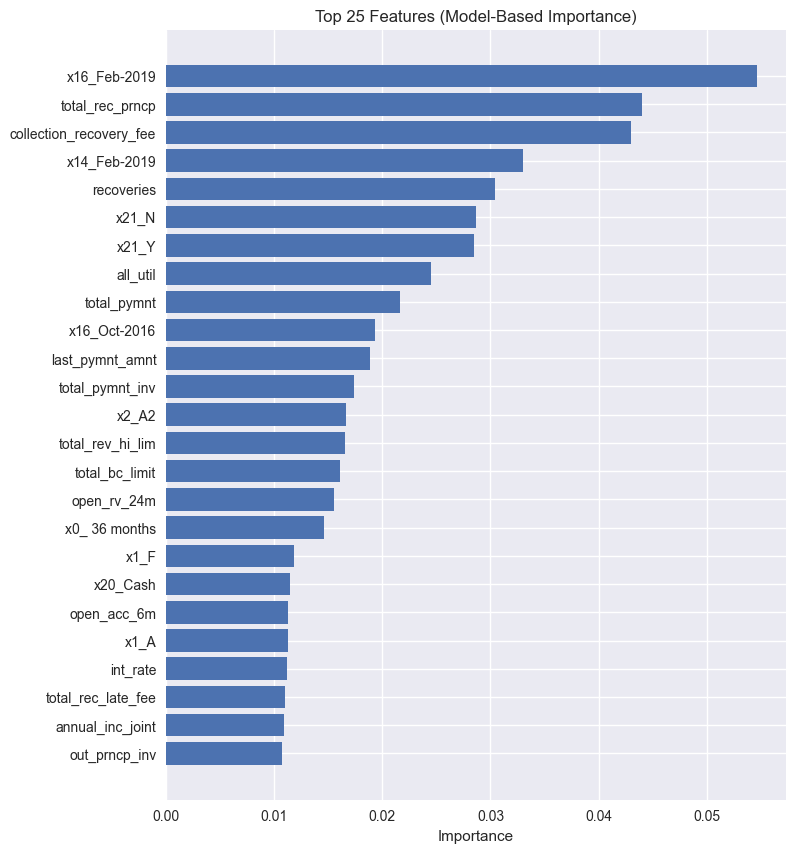

In [21]:
importances = clf.feature_importances_
top_idx = np.argsort(importances)[-25:]

plt.figure(figsize=(8,10))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.title("Top 25 Features (Model-Based Importance)")
plt.xlabel("Importance")
plt.show()


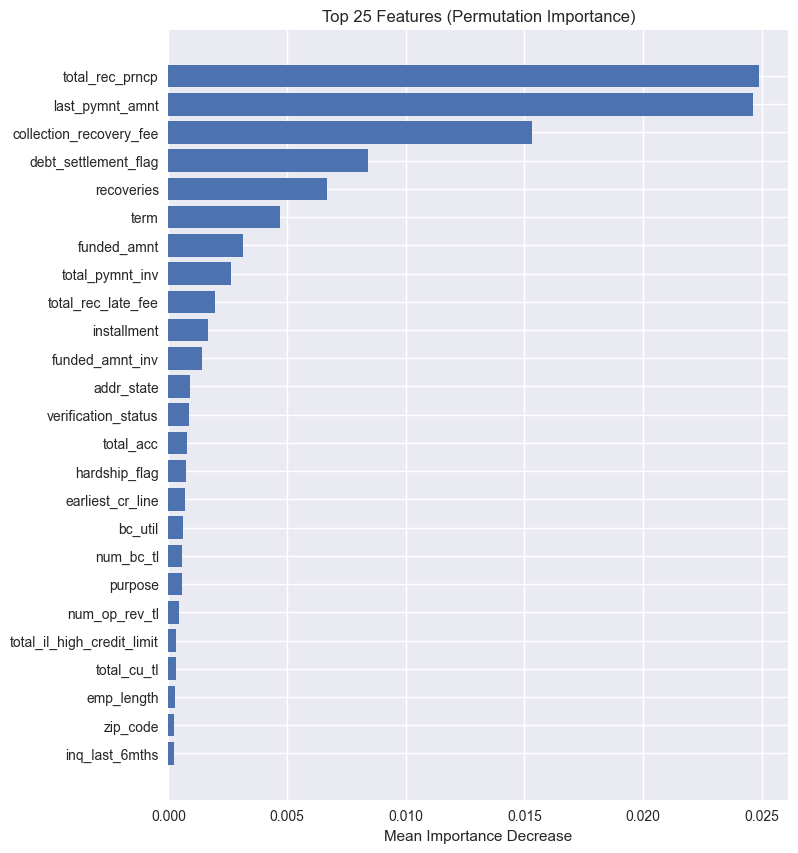

In [23]:
# Cell 5 (FIXED): Permutation importance on full pipeline

SAMPLE_SIZE = 5000
idx = np.random.choice(len(X), SAMPLE_SIZE, replace=False)

X_sample = X.iloc[idx]
y_sample = y.iloc[idx]

perm = permutation_importance(
    model,          # <-- FULL PIPELINE (important!)
    X_sample,       # <-- RAW FEATURES, not transformed
    y_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Get top features
top_idx = np.argsort(perm.importances_mean)[-25:]

plt.figure(figsize=(8,10))
plt.barh(
    X_sample.columns[top_idx],
    perm.importances_mean[top_idx]
)
plt.title("Top 25 Features (Permutation Importance)")
plt.xlabel("Mean Importance Decrease")
plt.show()


PDP for int_rate


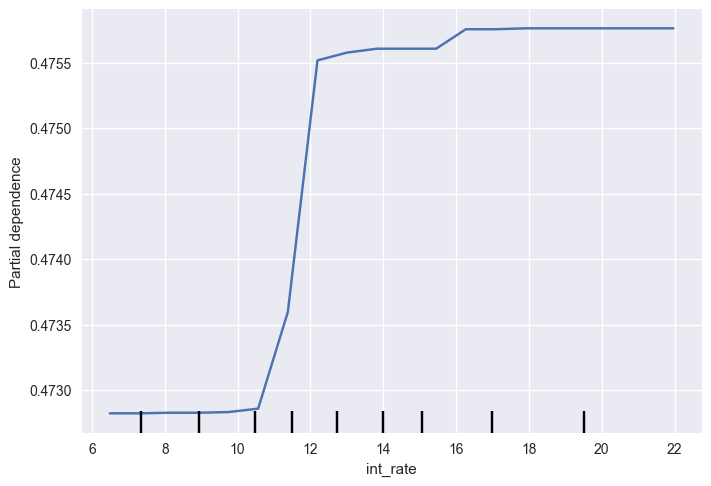

PDP for dti


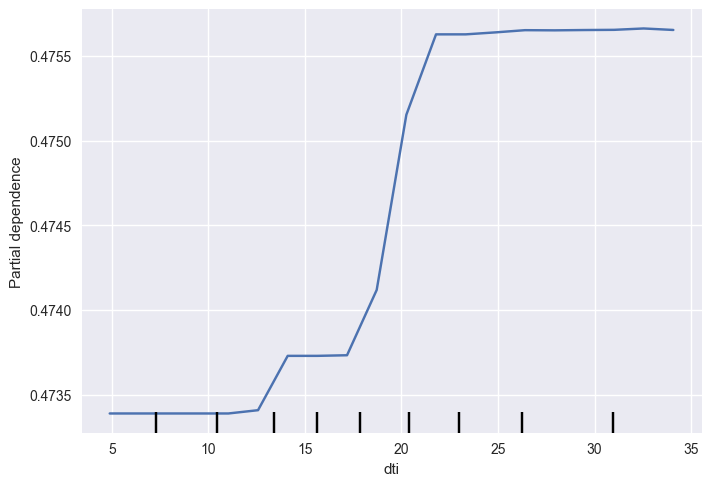

PDP for annual_inc


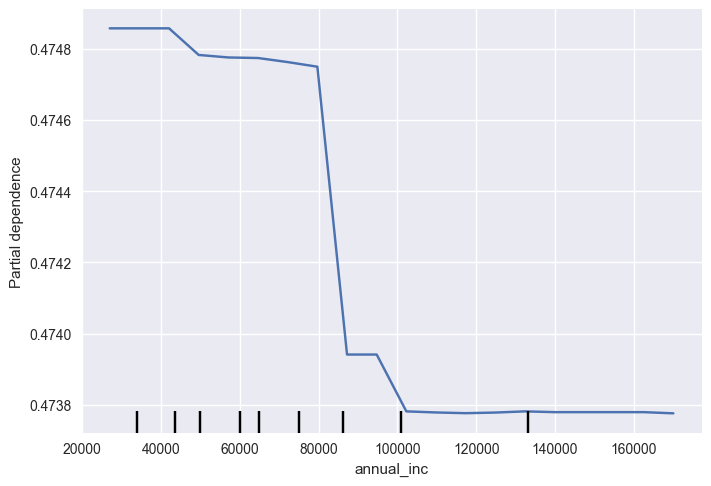

PDP for revol_util


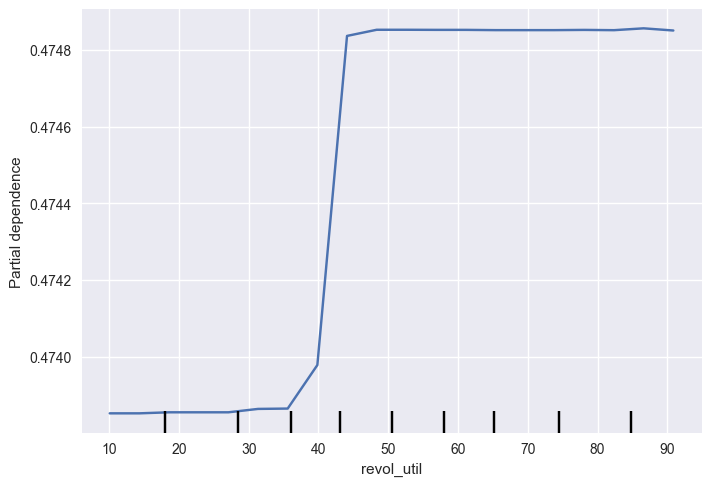

In [24]:
PDP_SAMPLE_SIZE = 3000
idx = np.random.choice(len(X), PDP_SAMPLE_SIZE, replace=False)
X_pdp = X.iloc[idx]

numeric_features = ["int_rate", "dti", "annual_inc", "revol_util"]

for feature in numeric_features:
    if feature in X.columns:
        print(f"PDP for {feature}")
        PartialDependenceDisplay.from_estimator(
            model,
            X_pdp,
            [feature],
            grid_resolution=20
        )
        plt.show()


Surrogate regression tree trained.


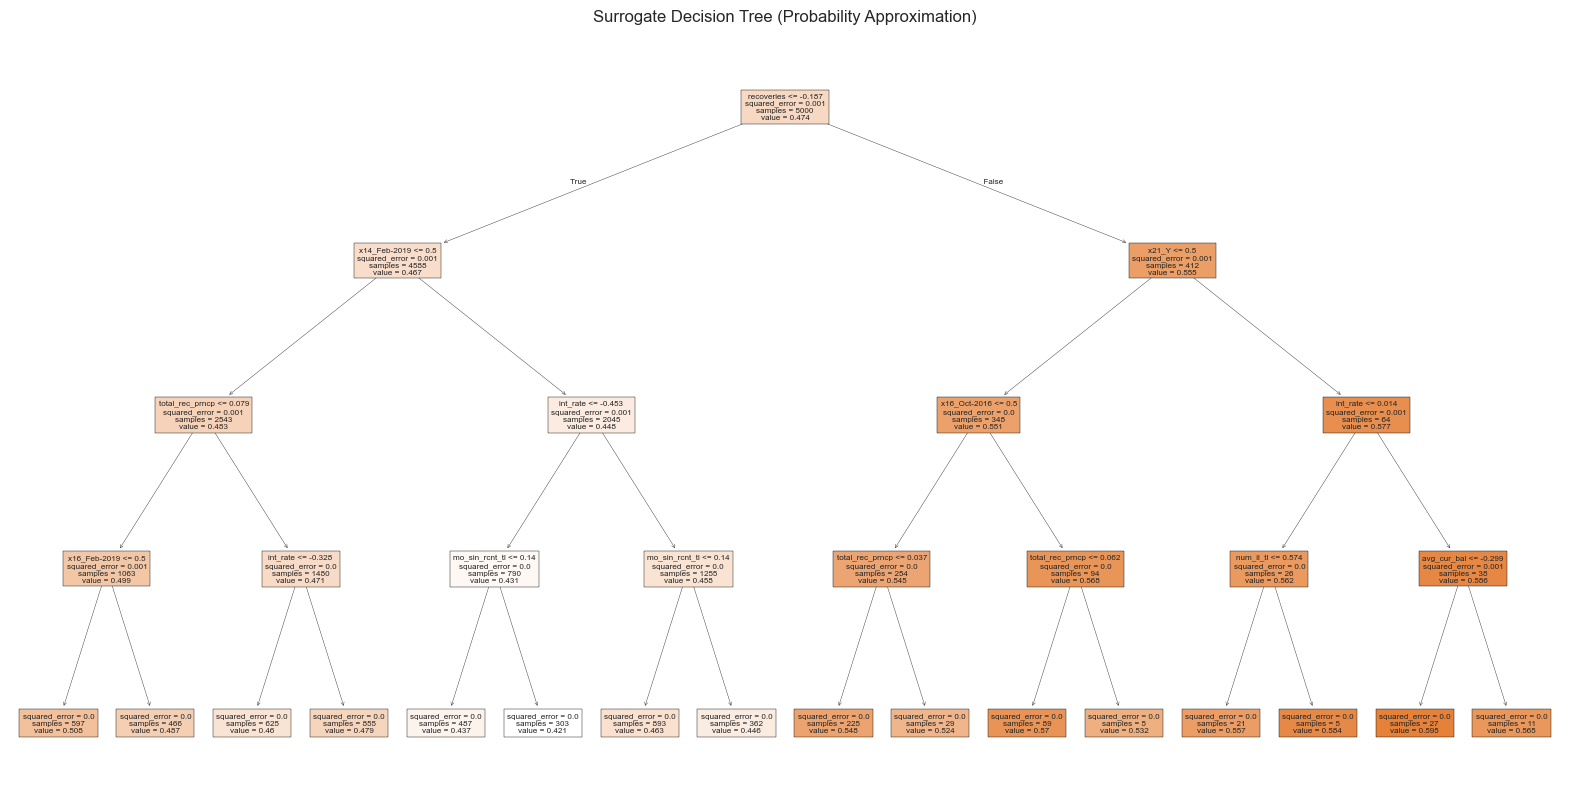

In [26]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Train a surrogate REGRESSION tree to mimic probability outputs
surrogate = DecisionTreeRegressor(
    max_depth=4,
    random_state=42
)

# Fit on transformed sample
surrogate.fit(
    X_transformed,
    clf.predict_proba(X_transformed)[:, 1]  # continuous probabilities
)

print("Surrogate regression tree trained.")

plt.figure(figsize=(20,10))
plot_tree(
    surrogate,
    feature_names=feature_names,
    filled=True,
    max_depth=4
)
plt.title("Surrogate Decision Tree (Probability Approximation)")
plt.show()


In [29]:
# Cell: Local explanation via surrogate regression tree (FINAL)

# Select one applicant to explain
idx = 10
x_instance = pre.transform(X.iloc[[idx]])

# Prediction from the main (black-box) model
prob = clf.predict_proba(x_instance)[0, 1]
pred = int(prob >= 0.5)

print("Applicant index:", idx)
print("Prediction:", "Default" if pred else "Good")
print("Probability of default:", round(prob, 4))

# Extract decision path from surrogate regression tree
node_indicator = surrogate.decision_path(x_instance)
leaf_id = surrogate.apply(x_instance)

tree_ = surrogate.tree_
feature = tree_.feature
threshold = tree_.threshold

print("\nDecision rules followed (surrogate model):")

for node_id in node_indicator.indices:
    # Skip leaf node
    if node_id == leaf_id[0]:
        print(f"Reached leaf node {node_id}")
        continue

    feat_id = feature[node_id]
    if feat_id != -2:  # -2 means leaf
        feat_name = feature_names[feat_id]
        thresh = threshold[node_id]
        value = x_instance[0, feat_id]

        if value <= thresh:
            print(f" - {feat_name} <= {thresh:.4f}")
        else:
            print(f" - {feat_name} > {thresh:.4f}")


Applicant index: 10
Prediction: Good
Probability of default: 0.4555

Decision rules followed (surrogate model):
 - recoveries <= -0.1874
 - x14_Feb-2019 > 0.5000
 - int_rate > -0.4529
 - mo_sin_rcnt_tl <= 0.1400
Reached leaf node 14
